In [1]:
from tandem import  TWCFTA, TWFCTA
from simultaneous import T3Clus, TFKMeans, CT3Clus
from simultaneous import CT3Clus
import numpy as np
from utils import PseudoF, OneKMeans
from sklearn.datasets import make_blobs
from tensor import fold, unfold
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

import pandas as pd
from tabulate import tabulate

import seaborn as sns
import array_to_latex as a2l

from utils import random_membership_matrix
from utils import singular_vectors

from sklearn.decomposition import PCA
import plotly.express as px

**Varimax Rotation**


In [2]:
def rotate(X, gamma=1, n_max_iter=20, tol=1e-6, method="varimax"):

	"""
    Return rotated components or loading matrix.

    Args:
        X (ndarray) : (IxJ) component scores matrix.
        n_components (int) : number of components to return.
        method (str) : method used for the transformation.
        tol (float) : tolerance for convergence.
        max_iter (int) : maximum number of iteration.

    Returns:
        ndarray: (IxJ) rotated matrix via the specified method.
    """

	nrows, ncols = X.shape
	rotation_matrix = np.eye(ncols)
	var0 = 0
	
	for i in range(n_max_iter):
		rotated_mat = X @ rotation_matrix
		if method == "varimax":
			tmp = (gamma/nrows) * rotated_mat @ np.diag(np.diag(rotated_mat.T @ rotated_mat))
		elif method == "quartimax":
			tmp = 0
		u,s,vh = np.linalg.svd(X.T @ (np.asarray(rotated_mat)**3 - tmp))
		rotation_matrix = u @ vh
		var_new = sum(s)
		if var0 != 0 and var_new < var0 * (1 + tol): break
		
		var0 = var_new

	return X @ rotation_matrix


def sort_loadings_matrix(C_k_r):
	
	# constructs a membership function assigning each object/variable/occasion to factor with largest score.
	# varimax approach. Ignoring possibility of object associated with multiple factors.
	# a thought to remove factor with no association (not implemented tho).

	rot_comps = rotate(C_k_r)

	#  construct membership function for component scores
	C_k_r_labels = np.argmax(abs(rot_comps), axis=1)  # factor assignment list for objects 
	C_k_r_mem = np.zeros(C_k_r.shape)  # initialize membership function matrix for objects
	for i in range(len(C_k_r_labels)):
		p = C_k_r_labels[i]  # choose a random cluster for the i'th object.
		C_k_r_mem[i,p] = 1  # assign object i to cluster p

	# sort rows of membership matrix,, grouping objects belonging to same factor.
	C_k_r_ind_lab = {_:C_k_r_labels[_] for _ in range(len(C_k_r_labels))}  # get dict of object to factor assignment
	C_k_r_ind_lab_sorted = dict(sorted(C_k_r_ind_lab.items(), key=lambda item: item[1], reverse=False))  # get sorted index of members
	C_k_r_mem_sorted = C_k_r_mem[list(C_k_r_ind_lab_sorted.keys())]  # sort membership function for occassions 

	return rot_comps, C_k_r_mem, C_k_r_mem_sorted, C_k_r_ind_lab_sorted


**Synthetic Dataset**

In [3]:
I,J,K = 8,5,4
# I,J,K = 50,100,5
X_i_jk, y = make_blobs(n_samples=I, centers=3, n_features=J*K, random_state=0)

G,Q,R = 3,3,2
# G,Q,R = I,J,K

# Q = int((J-1)/2)
# R = int((K-1)/2)
# G = 4
# # G,Q,R = 4,J,K
# G,Q,R


In [4]:
# 8x3
U_i_g_ = np.array([
	[1,0,0],
	[1,0,0],
	[1,0,0],
	[0,1,0],
	[0,1,0],
	[0,0,1],
	[0,0,1],
	[0,0,1]
])

# 6x3
B_j_q_ = np.array([
	[(2**0.5)/2,0,0],
	[(2**0.5)/2,0,0],
	[0,(2**0.5)/2,0],
	[0,(2**0.5)/2,0],
	[0,0,1],
])

# 4x2
C_k_r_ = np.array([
	[(3**0.5)/3,0],
	[(3**0.5)/3,0],
	[(3**0.5)/3,0],
	[0,1]
])

# 3x6
Y_g_qr_ = np.array([
	[(2/3)**0.5,1,-1, 2/3,-2,2**0.5],
	[-(1/3)**0.5,1,2, 1/3,-1,0.5],
	[(2/3)**0.5,-2,1, -2/3,1,2**0.5]
])

U_labels = np.where(U_i_g_)[1]
B_labels = np.where(B_j_q_)[1]
C_labels = np.where(C_k_r_)[1]

In [62]:
seed = 0
np.random.seed(seed)  # initialize numpyy random number generator
std = 0.8
E = np.random.normal(loc=0, scale=std, size=(I,J*K))
Z_i_jk = U_i_g_@Y_g_qr_@np.kron(C_k_r_,B_j_q_).T
X_i_jk_ = Z_i_jk + E

# convert original data to 3-mode tensor
X_i_j_k_ = fold(X_i_jk_, mode=1, shape=(K,I,J))
Z_i_j_k_ = fold(Z_i_jk, mode=1, shape=(K,I,J))

# data standardization
X_i_jk_s = scale(X_i_jk_)

# initializing parameters randomly
U_i_g0 = random_membership_matrix(I,G,seed=seed)

B_j_j = np.random.randn(J,J)
B_j_q0 = singular_vectors(B_j_j,Q)

C_k_k = np.random.randn(K,K)
C_k_r0 = singular_vectors(C_k_k,R)

# orthogonality check
# B_j_q0.T@B_j_q0
# C_k_r0.T@C_k_r0

# # initialization to latex
# a2l.to_ltx(B_j_q0, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r0, frmt = '{:6.2f}', arraytype='bmatrix')

In [6]:
# # Plotting synthetic data X
# pca = PCA(n_components=2)
# fig, axes = plt.subplots(2, K//2, figsize=(10, 10), sharex=True, sharey=True, dpi=100)
# # fig.suptitle('Synthetic Data Distribution')

# occasions = list(range(1,5))[::-1]
# k = 0
# for row in range(2):
# 	for col in range(2):
# 		components = pca.fit_transform(X_i_j_k_[k])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		# components['cluster'] = U_labels
# 		components['cluster'] = np.where(U_i_g_cf)[1]
# 		sns.scatterplot(ax=axes[row, col], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=160)
# 		axes[row, col].set_title(f'Occasion (K={k+1})')

# 		cents = pca.fit_transform(Z_i_j_k_[col])  # get each X face
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		# cents['cluster'] = U_labels
# 		sns.scatterplot(ax=axes[row, col], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(8), palette=[0 for _ in range(8)], legend=False, s=100)
		
# 		# cents = pca.fit_transform(X_g_j_k_cf[col])  # get each X face
# 		# cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		# sns.scatterplot(ax=axes[row, col], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0 for _ in range(3)], legend=False, s=100)

# 		k += 1

# plt.savefig('synthetic_data_distribution_Xijk.png')
# # plt.savefig('synthetic_data_distribution_fc_km.png')


In [7]:
# Scaling the Dataset
# X_i_jk_scaled = scale(X_i_jk)
X_i_jk_scaled = X_i_jk_s

# Q = int((J-1)/2)
# R = int((K-1)/2)
# G = 4

# G,Q,R = 2,6,K
# (I,J,K),(G,Q,R)

**Random Init**

In [8]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [9]:

# plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['axes.titlesize'] = 15

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(15, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.3, wspace=0.3)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=10)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

# 		plt.savefig('synthetic_Yiqr_ct3Clus_random.png')

In [10]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

*Varimax*

In [11]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


*metrics*

In [12]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# C_rand_ct0 = adjusted_rand_score(np.where(C_k_r_mem_ct0)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)
# C_rand_ct025 = adjusted_rand_score(np.where(C_k_r_mem_ct025)[1], C_labels)


# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)
# C_rand_ct05 = adjusted_rand_score(np.where(C_k_r_mem_ct05)[1], C_labels)


# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)
# C_rand_ct075 = adjusted_rand_score(np.where(C_k_r_mem_ct075)[1], C_labels)


# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# C_rand_ct1 = adjusted_rand_score(np.where(C_k_r_mem_ct1)[1], C_labels)


# # F0,F,BSS%, PF, Urand, Brand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[1],U_rand_ct0, B_rand_ct0, C_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[1],U_rand_ct025, B_rand_ct025, C_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[1],U_rand_ct05, B_rand_ct05, C_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[1],U_rand_ct075, B_rand_ct075, C_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[1],U_rand_ct1, B_rand_ct1, C_rand_ct1]).round(3))


**TWCFTA Initialization**

In [13]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [14]:

# plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['axes.titlesize'] = 15

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(15, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.3, wspace=0.3)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=10)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

# 		plt.savefig('synthetic_Yiqr_ct3Clus_twcfta.png')

In [15]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

*Varimax*

In [16]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


*Metrics*

In [17]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# C_rand_ct0 = adjusted_rand_score(np.where(C_k_r_mem_ct0)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)
# C_rand_ct025 = adjusted_rand_score(np.where(C_k_r_mem_ct025)[1], C_labels)


# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)
# C_rand_ct05 = adjusted_rand_score(np.where(C_k_r_mem_ct05)[1], C_labels)


# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)
# C_rand_ct075 = adjusted_rand_score(np.where(C_k_r_mem_ct075)[1], C_labels)


# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# C_rand_ct1 = adjusted_rand_score(np.where(C_k_r_mem_ct1)[1], C_labels)


# # F0,F,BSS%, PF, Urand, Brand, Crand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[1],U_rand_ct0, B_rand_ct0, C_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[1],U_rand_ct025, B_rand_ct025, C_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[1],U_rand_ct05, B_rand_ct05, C_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[1],U_rand_ct075, B_rand_ct075, C_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[1],U_rand_ct1, B_rand_ct1, C_rand_ct1]).round(3))


In [18]:
# a2l.to_ltx(B_j_q_mem_ct05, frmt = '{:6.0f}', arraytype='tabular')


**TWFCTA Init**

In [19]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=5000, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [20]:

# plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['axes.titlesize'] = 15

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(15, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.3, wspace=0.3)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=10)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

# 		plt.savefig('synthetic_Yiqr_ct3Clus_twfcta.png')

In [21]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

In [22]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


In [23]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# C_rand_ct0 = adjusted_rand_score(np.where(C_k_r_mem_ct0)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)
# C_rand_ct025 = adjusted_rand_score(np.where(C_k_r_mem_ct025)[1], C_labels)


# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)
# C_rand_ct05 = adjusted_rand_score(np.where(C_k_r_mem_ct05)[1], C_labels)


# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)
# C_rand_ct075 = adjusted_rand_score(np.where(C_k_r_mem_ct075)[1], C_labels)


# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# C_rand_ct1 = adjusted_rand_score(np.where(C_k_r_mem_ct1)[1], C_labels)


# # F0,F,BSS%, PF, Urand, Brand, Crand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[1],U_rand_ct0, B_rand_ct0, C_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[1],U_rand_ct025, B_rand_ct025, C_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[1],U_rand_ct05, B_rand_ct05, C_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[1],U_rand_ct075, B_rand_ct075, C_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[1],U_rand_ct1, B_rand_ct1, C_rand_ct1]).round(3))


In [24]:
# a2l.to_ltx(C_k_r_mem_ct1, frmt = '{:6.0f}', arraytype='tabular')

In [25]:
# alpha=1
# C = ct1.C_k_r
# B = ct1.B_j_q
# U = ct1.U_i_g
# I_jk_jk = np.eye(J*K)

# P = np.kron(C@C.T, B@B.T)
# X_N = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# # Y_i = X_N@np.kron(C, B)

# Y_i=fold(X_N@np.kron(C, B), mode=1, shape=(R,I,Q))
# Y_i=fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q))
# a2l.to_ltx(Y_i[0], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_i[1], frmt = '{:6.2f}', arraytype='bmatrix')

# # Z_i = U@np.linalg.inv(U.T@U)@U.T@X_N@np.kron(C,B)
# # Y_i = X_N @np.kron(C,B)
# # (Z_i.var()*Z_i.size)/(Y_i.var()*Y_i.size)


**SVD Initialization**

In [26]:
# PLOTTING THE COMPONENTS

Xs = []
Us = []
Yis = []
Ygs = []

ct0 = CT3Clus(
	verbose=True, init='svd', n_loops=5000, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
X_i_jk_n = ct0.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
Us.append(ct0.U_i_g)
Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct025 = CT3Clus(
	verbose=True, init='svd', n_loops=5000, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
X_i_jk_n = ct025.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
Us.append(ct025.U_i_g)
Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct05 = CT3Clus(
	verbose=True, init='svd', n_loops=5000, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
X_i_jk_n = ct05.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
Us.append(ct05.U_i_g)
Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct075 = CT3Clus(
	verbose=True, init='svd', n_loops=5000, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
X_i_jk_n = ct075.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
Us.append(ct075.U_i_g)
Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct1 = CT3Clus(
	verbose=True, init='svd', n_loops=5000, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
X_i_jk_n = ct1.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
Us.append(ct1.U_i_g)
Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    2    0.0043    44.2579    5.4856    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    8    0.008    35.7614    3.8463    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    10    0.008    25.7215    2.3925    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    6    0.009    42.6928    5.1471    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    5    0.005    53.0525    7.8076    True


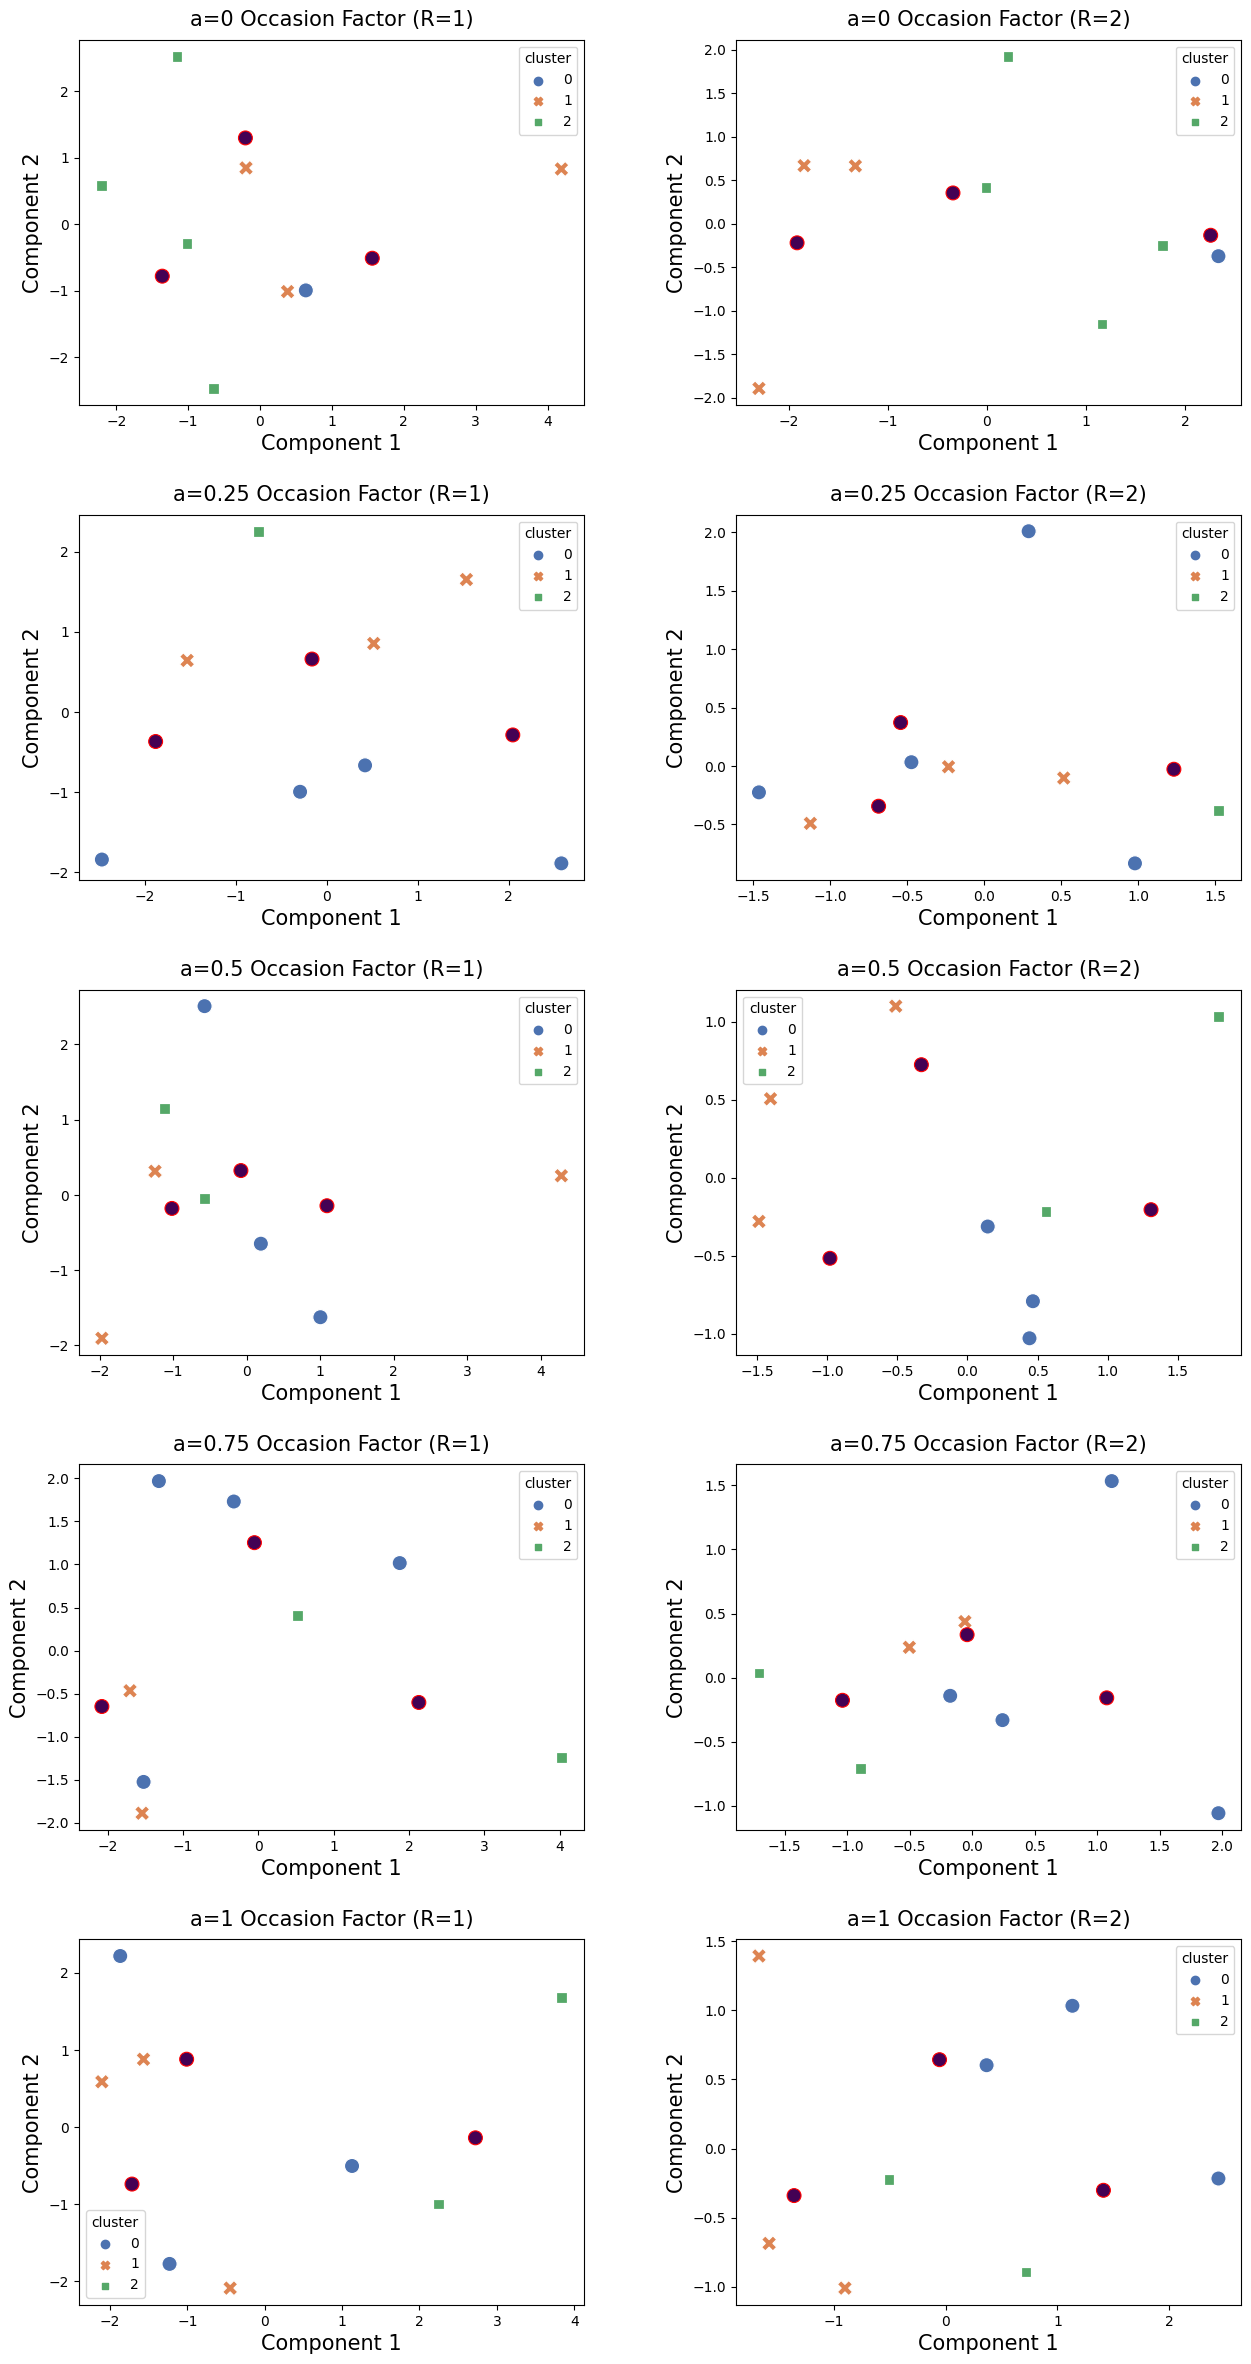

In [27]:

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

pca = PCA(n_components=2)
fig, axes = plt.subplots(5, R, figsize=(15, 30), sharex=False, sharey=False, dpi=100)
# fig.suptitle('Pokemon Stats by Generation')

fig.subplots_adjust(hspace=0.3, wspace=0.3)

titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# 
for clustering in range(5):
	# loop through each occasion factor
	for r in range(R):
		# extract first 2 components
		components = pca.fit_transform(Yis[clustering][r])  # get each X face
		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
		components['cluster']=np.where(Us[clustering])[1]

		# plot components in subplot
		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=10)

		# plotting centroids
		# if clustering > 0:
		cents = pca.fit_transform(Ygs[clustering][r])
		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

		plt.savefig('synthetic_Yiqr_ct3Clus_svd.png')

In [28]:
# tss,bss,pseudof
print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

ct0 [82.61 44.26  5.49]
ct025 [61.01 35.76  3.85]
ct05 [59.35 25.72  2.39]
ct075 [73.19 42.69  5.15]
ct1 [80.44 53.05  7.81]


In [29]:
# rotation and sorting of factor matrix
rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# to latex rotated matrices
# a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


In [30]:
# Rand and Pseudo F metrics
U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
C_rand_ct0 = adjusted_rand_score(np.where(C_k_r_mem_ct0)[1], C_labels)

U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)
C_rand_ct025 = adjusted_rand_score(np.where(C_k_r_mem_ct025)[1], C_labels)


U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)
C_rand_ct05 = adjusted_rand_score(np.where(C_k_r_mem_ct05)[1], C_labels)


U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)
C_rand_ct075 = adjusted_rand_score(np.where(C_k_r_mem_ct075)[1], C_labels)


U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
C_rand_ct1 = adjusted_rand_score(np.where(C_k_r_mem_ct1)[1], C_labels)


# F0,F,BSS%, PF, Urand, Brand, Crand
print('CT0:', np.array([ct0.Fs[0],ct0.Fs[1],U_rand_ct0, B_rand_ct0, C_rand_ct0]).round(3))
print('CT025:', np.array([ct025.Fs[0],ct025.Fs[1],U_rand_ct025, B_rand_ct025, C_rand_ct025]).round(3))
print('CT05:', np.array([ct05.Fs[0],ct05.Fs[1],U_rand_ct05, B_rand_ct05, C_rand_ct05]).round(3))
print('CT075:', np.array([ct075.Fs[0],ct075.Fs[1],U_rand_ct075, B_rand_ct075, C_rand_ct075]).round(3))
print('CT1:', np.array([ct1.Fs[0],ct1.Fs[1],U_rand_ct1, B_rand_ct1, C_rand_ct1]).round(3))


CT0: [ 4.451  5.473  0.478 -0.25   1.   ]
CT025: [ 4.322  3.917 -0.217 -0.25   0.   ]
CT05: [ 3.562  3.939  0.238 -0.25  -0.333]
CT075: [ 2.877  4.189  0.182 -0.25  -0.333]
CT1: [ 3.918  5.15   0.048 -0.25   0.   ]


In [43]:
a2l.to_ltx(C_k_r_mem_ct0, frmt = '{:6.0f}', arraytype='tabular')


\begin{tabular}
       1  &       0 \\
       1  &       0 \\
       1  &       0 \\
       0  &       1 
\end{tabular}


In [100]:
U=np.array([
	[1,0,0],
	[0,1,0],
	[0,0,1],
	[0,0,1],
	[0,1,0],
	[1,0,0],
	[0,0,1],
	[0,1,0],
])
B = np.array([
	[-0.67, 0.33, -0.47],
	[-0.44,-0.76,-0.13],
	[0.33,-0.04,-0.86],
	[-0.51,0.19,0.16],
	[0.01,-0.53,0]
])
C= np.array([
	[-0.71,0.61],
	[-0.4,-0.73],
	[-0.5,-0.12],
	[-0.28,-0.28]
])

In [102]:
Ziqr = U@np.linalg.inv(U.T@U)@U.T@X_i_jk_scaled@np.kron(C,B)
Yiqr = X_i_jk_scaled@np.kron(C,B)

In [103]:
np.linalg.norm(Ziqr,2)/(np.linalg.norm(Yiqr,2))

0.9311579662980805

In [ ]:
(Ziqr.var()*Ziqr.size)/(Z_i_jk.var()*Z_i_jk.size)

In [95]:
Zijk_=U@np.linalg.inv(U.T@U)@U.T@X_i_jk_scaled

In [96]:
np.linalg.norm(Zijk_,2)/(np.linalg.norm(Z_i_jk,2))

0.9077590169235265

In [97]:
(Zijk_.var()*Zijk_.size)/(Z_i_jk.var()*Z_i_jk.size)

0.772369084287024

In [98]:
(Zijk_.var()*Zijk_.size)/(X_i_jk_scaled.var()*Z_i_jk.size)

0.31979822249677226

In [31]:
dsdfdsf

NameError: name 'dsdfdsf' is not defined

**TANDEM MODELS**

In [ ]:
# PLOTTING THE COMPONENTS

Xs = []
Us = []
Yis = []
Ygs = []


cf=TWCFTA(verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# cf=TWCFTA(verbose=True, init='random', n_loops=5, n_max_iter=100, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# cf=TWCFTA(verbose=True, init='random', n_loops=5, n_max_iter=1000, tol=1e-3, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
X_i_jk_n = cf.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(cf.C_k_r, cf.B_j_q)
Us.append(cf.U_i_g)
Ygs.append(fold(cf.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


fc=TWFCTA(verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# fc=TWFCTA(verbose=True, init='random', n_loops=5, n_max_iter=100, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# fc=TWFCTA(verbose=True, init='random', n_loops=5, n_max_iter=1000, tol=1e-3, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
X_i_jk_n = fc.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(fc.C_k_r, fc.B_j_q)
Us.append(fc.U_i_g)
Ygs.append(fold(fc.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

pca = PCA(n_components=2)
fig, axes = plt.subplots(2, R, figsize=(10, 10), sharex=False, sharey=False, dpi=100)

fig.subplots_adjust(hspace=0.3, wspace=0.25)

titles = ['TWCFTA','TWFCTA']

# 
for clustering in range(2):
	# loop through each occasion factor
	for r in range(R):
		# extract first 2 components
		components = pca.fit_transform(Yis[clustering][r])  # get each X face
		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
		components['cluster']=np.where(Us[clustering])[1]

		# plot components in subplot
		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=10)

		# plotting centroids
		# if clustering > 0:
		cents = pca.fit_transform(Ygs[clustering][r])
		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

		plt.savefig('synthetic_Yiqr_tandem_clustering.png')

In [ ]:
print(cf.Fs_km)
print(cf.Fs_fa)
print()
print(fc.Fs_fa)
print(fc.Fs_km)

In [ ]:
a2l.to_ltx(fc.C_k_r, frmt = '{:6.2f}', arraytype='bmatrix')

In [ ]:
Z_i_jk=cf.U_i_g0@np.linalg.inv(cf.U_i_g0.T@cf.U_i_g0)@cf.U_i_g0.T@cf.X_i_jk_scaled 
np.linalg.norm(cf.X_i_jk_scaled - Z_i_jk,2)/np.linalg.norm(cf.X_i_jk_scaled,2)

In [ ]:
# Z_i_jk=fc.X_i_jk_scaled@np.kron(fc.C_k_r0@fc.C_k_r0.T, fc.B_j_q0@fc.B_j_q0.T) 
Y_g_qr=np.linalg.inv(fc.U_i_g0.T@fc.U_i_g0)@fc.U_i_g0.T @ X_i_jk_scaled @ np.kron(fc.C_k_r,fc.B_j_q)

# np.linalg.norm(Z_g_jk,2)/np.linalg.norm(X_g_jk,2)
# np.linalg.norm(cf.U_i_g@Y_g_qr,2)/np.linalg.norm(cf.X_i_jk_scaled@np.kron(cf.C_k_r,cf.B_j_q),2)

np.linalg.norm(fc.U_i_g0@fc.Y_g_qr,2)/np.linalg.norm(fc.X_i_jk_scaled,2)

In [ ]:
fc.B_j_q
a2l.to_ltx(cf.C_k_r, frmt = '{:6.2f}', arraytype='bmatrix')

In [ ]:
Y_i_qr0_cf = fold(np.linalg.inv(fc.U_i_g.T@fc.U_i_g)@fc.U_i_g.T@fc.X_i_jk_scaled@np.kron(fc.C_k_r, fc.B_j_q), mode=1, shape=(R,G,Q))
a2l.to_ltx(Y_i_qr0_cf[0], frmt = '{:6.2f}', arraytype='bmatrix')
a2l.to_ltx(Y_i_qr0_cf[1], frmt = '{:6.2f}', arraytype='bmatrix')

In [ ]:
gdfg

In [ ]:
# # get iterates
# U_i_g0_cf = cf.U_i_g0
# B_j_q0_cf = cf.B_j_q0
# C_k_r0_cf = cf.C_k_r0
# U_i_g_cf = cf.U_i_g
# B_j_q_cf = cf.B_j_q
# C_k_r_cf = cf.C_k_r
# Y_g_qr_cf = cf.Y_g_qr
# X_i_jk_cf = cf.X_i_jk_scaled
# Y_i_qr_cf = cf.X_i_jk_scaled @ np.kron(C_k_r_cf, B_j_q_cf)

# U_i_g0_fc = fc.U_i_g0
# B_j_q0_fc = fc.B_j_q0
# C_k_r0_fc = fc.C_k_r0
# U_i_g_fc = fc.U_i_g
# B_j_q_fc = fc.B_j_q
# C_k_r_fc = fc.C_k_r
# Y_g_qr_fc = fc.Y_g_qr
# X_i_jk_fc = fc.X_i_jk_scaled
# Y_i_qr_fc = fc.X_i_jk_scaled @ np.kron(C_k_r_fc, B_j_q_fc)

# # a2l.to_ltx(U_i_g_cf, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(B_j_q0_cf, frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r0_cf, frmt = '{:6.3f}', arraytype='bmatrix')


# # TWCFTA

# # U_i_g0_cf, B_j_q0_cf, C_k_r0_cf
# # a2l.to_ltx(U_i_g0_cf, frmt = '{:6.0f}', arraytype='bmatrix')

# # init K-means
# # X_g_jk0_cf = np.linalg.inv(U_i_g0_cf.T@U_i_g0_cf) @ U_i_g0_cf.T @ X_i_jk_cf
# # X_g_j_k0_cf = fold(X_g_jk0_cf, mode=1, shape=(K,G,J))
# # a2l.to_ltx(X_g_j_k0_cf[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k0_cf[1], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k0_cf[2], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k0_cf[3], frmt = '{:6.3f}', arraytype='bmatrix')

# # final K-means
# # X_g_jk_cf = np.linalg.inv(U_i_g_cf.T@U_i_g_cf) @ U_i_g_cf.T @ X_i_jk_cf
# # X_g_j_k_cf = fold(X_g_jk_cf, mode=1, shape=(K,G,J))
# # a2l.to_ltx(X_g_j_k_cf[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k_cf[1], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k_cf[2], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(X_g_j_k_cf[3], frmt = '{:6.3f}', arraytype='bmatrix')

# # init FA
# # a2l.to_ltx(B_j_q0_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r0_cf, frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_g_qr0_cf = np.linalg.inv(U_i_g_cf.T@U_i_g_cf) @ U_i_g_cf.T @ cf.X_i_jk_scaled @ np.kron(C_k_r0_cf, B_j_q0_cf)
# # Y_g_q_r0_cf = fold(Y_g_qr0_cf, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r0_cf[0], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r0_cf[1], frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_i_qr0_cf = cf.X_i_jk_scaled @ np.kron(C_k_r0_cf, B_j_q0_cf)
# # Y_i_q_r0_cf = fold(Y_i_qr0_cf, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r0_cf[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r0_cf[1], frmt = '{:6.3f}', arraytype='tabular')

# # final FA
# # a2l.to_ltx(B_j_q_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_cf, frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_g_qr_cf = np.linalg.inv(U_i_g_cf.T@U_i_g_cf) @ U_i_g_cf.T @ cf.X_i_jk_scaled @ np.kron(C_k_r_cf, B_j_q_cf)
# # Y_g_q_r_cf = fold(Y_g_qr0_cf, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r_cf[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_cf[1], frmt = '{:6.3f}', arraytype='bmatrix')

# # Y_i_qr_cf = cf.X_i_jk_scaled @ np.kron(C_k_r_cf, B_j_q_cf)
# # Y_i_q_r_cf = fold(Y_i_qr_cf, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r_cf[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_cf[1], frmt = '{:6.3f}', arraytype='tabular')


# # TWFCTA
# # init FA
# # a2l.to_ltx(B_j_q0_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r0_fc, frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_i_qr0_fc = X_i_jk_fc @ np.kron(C_k_r0_fc, B_j_q0_fc)
# # Y_i_q_r0_fc = fold(Y_i_qr0_fc, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r0_fc[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r0_fc[1], frmt = '{:6.3f}', arraytype='tabular')

# # final FA
# # a2l.to_ltx(B_j_q_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_fc, frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_i_qr_fc = X_i_jk_fc @ np.kron(C_k_r_fc, B_j_q_fc)
# # Y_i_q_r_fc = fold(Y_i_qr_fc, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r_fc[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_fc[1], frmt = '{:6.3f}', arraytype='tabular')

# # init K-means
# # a2l.to_ltx(U_i_g0_fc, frmt = '{:6.0f}', arraytype='bmatrix')

# # Y_g_qr0_fc = np.linalg.inv(U_i_g0_fc.T@U_i_g0_fc) @ U_i_g0_fc.T @ fc.X_i_jk_scaled @ np.kron(C_k_r_fc, B_j_q_fc)
# # Y_g_q_r0_fc = fold(Y_g_qr0_fc, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r0_fc[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r0_fc[1], frmt = '{:6.3f}', arraytype='bmatrix')

# # final kmeans
# # a2l.to_ltx(U_i_g_fc, frmt = '{:6.0f}', arraytype='bmatrix')

# # Y_g_qr_fc = np.linalg.inv(U_i_g_fc.T@U_i_g_fc) @ U_i_g_fc.T @ fc.X_i_jk_scaled @ np.kron(C_k_r_fc, B_j_q_fc)
# # Y_g_q_r_fc = fold(Y_g_qr_fc, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r_fc[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_fc[1], frmt = '{:6.3f}', arraytype='bmatrix')


# # a2l.to_ltx(U_i_g_fc, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(B_j_q_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_fc, frmt = '{:6.2f}', arraytype='bmatrix')



**Varimax Rotation**

In [ ]:
# rotation and sorting of factor matrix
rotated_C_cf, C_k_r_mem_cf, C_k_r_mem_sorted_cf, C_k_r_ind_lab_sorted_cf = sort_loadings_matrix(cf.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_cf, index=[_+1 for _ in C_k_r_ind_lab_sorted_cf.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_cf, B_j_q_mem_cf, B_j_q_mem_sorted_cf, B_j_q_ind_lab_sorted_cf = sort_loadings_matrix(cf.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_cf, index=[_+1 for _ in B_j_q_ind_lab_sorted_cf.keys()], columns=range(1,Q+1), dtype=int) #construct df of results

# rotation and sorting of factor matrix
rotated_C_fc, C_k_r_mem_fc, C_k_r_mem_sorted_fc, C_k_r_ind_lab_sorted_fc = sort_loadings_matrix(fc.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_fc, index=[_+1 for _ in C_k_r_ind_lab_sorted_fc.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_fc, B_j_q_mem_fc, B_j_q_mem_sorted_fc, B_j_q_ind_lab_sorted_fc = sort_loadings_matrix(fc.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_fc, index=[_+1 for _ in B_j_q_ind_lab_sorted_fc.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# to latex rotated matrices
# a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')

# a2l.to_ltx(rotated_B_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_fc, frmt = '{:6.2f}', arraytype='bmatrix')

# # to latex membership matrices
# a2l.to_ltx(B_j_q_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')

# a2l.to_ltx(B_j_q_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')


**Metrics**

In [ ]:
# Rand and Pseudo F metrics
U_rand_cf = adjusted_rand_score(np.where(cf.U_i_g)[1], U_labels)
B_rand_cf = adjusted_rand_score(np.where(B_j_q_mem_cf)[1], B_labels)
C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

U_rand_fc = adjusted_rand_score(np.where(fc.U_i_g)[1], U_labels)
B_rand_fc = adjusted_rand_score(np.where(B_j_q_mem_fc)[1], B_labels)
C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)

print('TWCFTA:', np.array([cf.TSS,cf.BSS/cf.TSS*100, cf.PseudoF, U_rand_cf, B_rand_cf, C_rand_cf]).round(3))
print('TWFCTA:', np.array([fc.TSS,fc.BSS/fc.TSS*100, fc.PseudoF, U_rand_fc, B_rand_fc, C_rand_fc]).round(3))


**CT3CLUS IMPLEMENTATION**

In [ ]:
# # PLOTTING THE COMPONENTS
# plot membership matrices on the original datasets

# Xs = [X_i_j_k_]
# Us = [U_i_g_]
# Ys = []


# alpha=0
# ct = CT3Clus(verbose=False, init='random', n_loops=1000, n_max_iter=100, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# Xs.append(fold(ct.X_i_jk_scaled, mode=1, shape=(K,I,J)))
# Us.append(ct.U_i_g)
# Y_g_q_r = fold(ct.Y_g_qr@np.kron(ct.C_k_r,ct.B_j_q).T, mode=1, shape=(K,G,J))
# Ys.append(Y_g_q_r)

# alpha=1
# ct = CT3Clus(verbose=False, init='random', n_loops=1000, n_max_iter=100, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# Xs.append(fold(ct.X_i_jk_scaled, mode=1, shape=(K,I,J)))
# Us.append(ct.U_i_g)
# Y_g_q_r = fold(ct.Y_g_qr@np.kron(ct.C_k_r,ct.B_j_q).T, mode=1, shape=(K,G,J))
# Ys.append(Y_g_q_r)


# pca = PCA(n_components=2)
# fig, axes = plt.subplots(3, K, figsize=(20, 15), sharex=True, sharey=True)
# # fig.suptitle('Pokemon Stats by Generation')

# titles = ['Real','3FKMeans','T3Clus']

# # 
# for clustering in range(3):
# 	# loop through each occasion
# 	for k in range(K):
# 		# extract first 2 components
# 		components = pca.fit_transform(Xs[clustering][k])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, k], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=70)
# 		axes[clustering, k].set_title(f'{titles[clustering]} Occasion {k+1}')

# 		# plotting centroids
# 		if clustering > 0:
# 			cents = pca.fit_transform(Ys[clustering-1][k])
# 			cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 			sns.scatterplot(ax=axes[clustering, k], data=cents, x='Component 1', y='Component 2', ec='black', hue=range(3), palette=[0,0,0], legend=False)

# 		plt.savefig('synthetic_after_iteration1000.png')


In [ ]:
# PLOTTING THE COMPONENTS

Xs = []
Us = []
Yis = []
Ygs = []


alpha=0
ct0 = CT3Clus(verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# ct0 = CT3Clus(verbose=True, init='random', n_loops=1, n_max_iter=1000, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# ct0 = CT3Clus(verbose=False, init='random', n_loops=1000, n_max_iter=10, tol=1e-3).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
X_i_jk_n = ct0.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
Us.append(ct0.U_i_g)
Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


alpha=1
ct1 = CT3Clus(verbose=True, init='random', n_loops=5000, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# ct1 = CT3Clus(verbose=True, init='random', n_loops=1, n_max_iter=1000, tol=1e-3, U_i_g=U_i_g0, B_j_q=B_j_q0, C_k_r=C_k_r0).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
# ct1 = CT3Clus(verbose=False, init='random', n_loops=1000, n_max_iter=10, tol=1e-3).fit(X_i_jk=X_i_jk_, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
X_i_jk_n = ct1.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
Us.append(ct1.U_i_g)
Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

pca = PCA(n_components=2)
fig, axes = plt.subplots(2, R, figsize=(10, 10), sharex=False, sharey=False, dpi=100)
# fig.suptitle('Pokemon Stats by Generation')

fig.subplots_adjust(hspace=0.25, wspace=0.25)

titles = ['3FKMeans','T3Clus']

# 
for clustering in range(2):
	# loop through each occasion factor
	for r in range(R):
		# extract first 2 components
		components = pca.fit_transform(Yis[clustering][r])  # get each X face
		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
		components['cluster']=np.where(Us[clustering])[1]

		# plot components in subplot
		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})')

		# plotting centroids
		# if clustering > 0:
		cents = pca.fit_transform(Ygs[clustering][r])
		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

		plt.savefig('synthetic_after_iterationYs.png')

In [ ]:
pca = PCA(n_components=2)
fig, axes = plt.subplots(2, R, figsize=(10, 10), sharex=False, sharey=False, dpi=100)
# fig.suptitle('Pokemon Stats by Generation')

fig.subplots_adjust(hspace=0.3, wspace=0.25)

titles = ['3FKMeans','T3Clus']

# 
for clustering in range(2):
	# loop through each occasion factor
	for r in range(R):
		# extract first 2 components
		components = pca.fit_transform(Yis[clustering][r])  # get each X face
		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
		components['cluster']=np.where(Us[clustering])[1]

		# plot components in subplot
		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})')

		# plotting centroids
		# if clustering > 0:
		cents = pca.fit_transform(Ygs[clustering][r])
		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(3), palette=[0,0,0], legend=False, s=100)

		plt.savefig('synthetic_after_iterationYs.png')

In [ ]:
# # BSS percent
print('3FKMeans',ct0.BSS/ct0.TSS)
print('CT3Clus',ct1.BSS/ct1.TSS)

In [ ]:
print('ct0',ct0.Fs)
print('ct1',ct1.Fs)

In [ ]:
ct0.B_j_q

In [ ]:
a2l.to_ltx(ct1.B_j_q, frmt = '{:6.2f}', arraytype='bmatrix')

In [ ]:
# F0_ct0=np.linalg.norm(X_i_jk_N_ct0-U_i_g0_ct0@Y_g_qr0_ct0@np.kron(C_k_r0_ct0, B_j_q0_ct0).T,2)
# F0_ct1=np.linalg.norm(X_i_jk_N_ct1-U_i_g0_ct1@Y_g_qr0_ct1@np.kron(C_k_r0_ct1, B_j_q0_ct1).T,2)

# TSS0_ct0 = ((Y_i_qr0_ct0).var()*(Y_i_qr0_ct0).size)
# TSS0_ct1 = ((Y_i_qr0_ct1).var()*(Y_i_qr0_ct1).size)
# BSS0_ct0 = ((U_i_g0_ct0@Y_g_qr0_ct0).var()*(U_i_g0_ct0@Y_g_qr0_ct0).size)
# BSS0_ct1 = ((U_i_g0_ct1@Y_g_qr0_ct1).var()*(U_i_g0_ct1@Y_g_qr0_ct1).size)
# BSS0_ct0_per = BSS0_ct0/TSS0_ct0
# BSS0_ct1_per = BSS0_ct1/TSS0_ct1

# PF0 = PseudoF(BSS0_ct0, TSS0_ct0-BSS0_ct0, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# PF1 = PseudoF(BSS0_ct1, TSS0_ct1-BSS0_ct1, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))

# print("ct0:",F0_ct0,TSS0_ct0,BSS0_ct0,BSS0_ct0_per,PF0)
# print("ct1:",F0_ct1,TSS0_ct1,BSS0_ct1,BSS0_ct1_per,PF1)

# F_ct0=np.linalg.norm(X_i_jk_N_ct0-U_i_g_ct0@Y_g_qr_ct0@np.kron(C_k_r_ct0, B_j_q_ct0).T,2)
# F_ct1=np.linalg.norm(X_i_jk_N_ct1-U_i_g_ct1@Y_g_qr_ct1@np.kron(C_k_r_ct1, B_j_q_ct1).T,2)

# TSS_ct0 = ((Y_i_qr_ct0).var()*(Y_i_qr_ct0).size)
# TSS_ct1 = ((Y_i_qr_ct1).var()*(Y_i_qr_ct1).size)
# BSS_ct0 = ((U_i_g_ct0@Y_g_qr_ct0).var()*(U_i_g_ct0@Y_g_qr_ct0).size)
# BSS_ct1 = ((U_i_g_ct1@Y_g_qr_ct1).var()*(U_i_g_ct1@Y_g_qr_ct1).size)
# BSS_ct0_per = BSS_ct0/TSS_ct0
# BSS_ct1_per = BSS_ct1/TSS_ct1

# PF0 = PseudoF(BSS_ct0, TSS_ct0-BSS_ct0, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# PF1 = PseudoF(BSS_ct1, TSS_ct1-BSS_ct1, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# print("ct0:", F_ct0, TSS_ct0, BSS_ct0, BSS_ct0_per, PF0)
# print("ct1:", F_ct1, TSS_ct1, BSS_ct1, BSS_ct1_per, PF1)


In [ ]:
# # 3FKMEANS
# P = np.kron(ct0.C_k_r0 @ ct0.C_k_r0.T, ct0.B_j_q0 @ ct0.B_j_q0.T)
# X_i_jk0_ct0 = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# Z_i_jk0_ct0 = ct0.U_i_g0 @ np.linalg.inv(ct0.U_i_g0.T@ct0.U_i_g0) @ ct0.U_i_g0.T @ X_i_jk0_ct0 @ np.kron(ct0.C_k_r0@ct0.C_k_r0.T, ct0.B_j_q0@ct0.B_j_q0.T)
# F0_ct0 = np.linalg.norm(X_i_jk0_ct0-Z_i_jk0_ct0,2)

# Y_g_qr0_ct0 = np.linalg.inv(ct0.U_i_g0.T@ct0.U_i_g0) @ ct0.U_i_g0.T @ X_i_jk0_ct0 @ np.kron(ct0.C_k_r0, ct0.B_j_q0)
# Z_i_qr0_ct0 = ct0.U_i_g0 @ Y_g_qr0_ct0
# Y_i_qr0_ct0 = X_i_jk0_ct0 @ np.kron(ct0.C_k_r0, ct0.B_j_q0)
# BSS0_ct0 = Z_i_qr0_ct0.var()*Z_i_qr0_ct0.size
# TSS0_ct0 = Y_i_qr0_ct0.var()*Y_i_qr0_ct0.size
# BSS0_ct0_per = BSS0_ct0/TSS0_ct0

# P = np.kron(ct0.C_k_r @ ct0.C_k_r.T, ct0.B_j_q @ ct0.B_j_q.T)
# X_i_jk_ct0 = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# Z_i_jk_ct0 = ct0.U_i_g @ np.linalg.inv(ct0.U_i_g.T@ct0.U_i_g) @ ct0.U_i_g.T @ X_i_jk_ct0 @ np.kron(ct0.C_k_r@ct0.C_k_r.T, ct0.B_j_q@ct0.B_j_q.T)
# F_ct0 = np.linalg.norm(X_i_jk_ct0-Z_i_jk_ct0,2)

# Y_g_qr_ct0 = np.linalg.inv(ct0.U_i_g.T@ct0.U_i_g) @ ct0.U_i_g.T @ X_i_jk_ct0 @ np.kron(ct0.C_k_r, ct0.B_j_q)
# Z_i_qr_ct0 = ct0.U_i_g @ Y_g_qr_ct0
# Y_i_qr_ct0 = X_i_jk_ct0 @ np.kron(ct0.C_k_r, ct0.B_j_q)
# BSS_ct0 = Z_i_qr_ct0.var()*Z_i_qr_ct0.size
# TSS_ct0 = Y_i_qr_ct0.var()*Y_i_qr_ct0.size
# BSS_ct0_per = BSS_ct0/TSS_ct0

# # T3CLUS
# P = np.kron(ct1.C_k_r0 @ ct1.C_k_r0.T, ct1.B_j_q0 @ ct1.B_j_q0.T)
# X_i_jk0_ct1 = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# Z_i_jk0_ct1 = ct1.U_i_g0 @ np.linalg.inv(ct1.U_i_g0.T@ct1.U_i_g0) @ ct1.U_i_g0.T @ X_i_jk0_ct1 @ np.kron(ct1.C_k_r0@ct1.C_k_r0.T, ct1.B_j_q0@ct1.B_j_q0.T)
# F0_ct1 = np.linalg.norm(X_i_jk0_ct1-Z_i_jk0_ct1,2)

# Y_g_qr0_ct1 = np.linalg.inv(ct1.U_i_g0.T@ct1.U_i_g0) @ ct1.U_i_g0.T @ X_i_jk0_ct1 @ np.kron(ct1.C_k_r0, ct1.B_j_q0)
# Z_i_qr0_ct1 = ct1.U_i_g0 @ Y_g_qr0_ct1
# Y_i_qr0_ct1 = X_i_jk0_ct1 @ np.kron(ct1.C_k_r0, ct1.B_j_q0)
# BSS0_ct1 = Z_i_qr0_ct1.var()*Z_i_qr0_ct1.size
# TSS0_ct1 = Y_i_qr0_ct1.var()*Y_i_qr0_ct1.size
# BSS0_ct1_per = BSS0_ct1/TSS0_ct1

# P = np.kron(ct1.C_k_r @ ct1.C_k_r.T, ct1.B_j_q @ ct1.B_j_q.T)
# X_i_jk_ct1 = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# Z_i_jk_ct1 = ct1.U_i_g @ np.linalg.inv(ct1.U_i_g.T@ct1.U_i_g) @ ct1.U_i_g.T @ X_i_jk_ct1 @ np.kron(ct1.C_k_r@ct1.C_k_r.T, ct1.B_j_q@ct1.B_j_q.T)
# F_ct1 = np.linalg.norm(X_i_jk_ct1-Z_i_jk_ct1,2)

# Y_g_qr_ct1 = np.linalg.inv(ct1.U_i_g.T@ct1.U_i_g) @ ct1.U_i_g.T @ X_i_jk_ct1 @ np.kron(ct1.C_k_r, ct1.B_j_q)
# Z_i_qr_ct1 = ct1.U_i_g @ Y_g_qr_ct1
# Y_i_qr_ct1 = X_i_jk_ct1 @ np.kron(ct1.C_k_r, ct1.B_j_q)
# BSS_ct1 = Z_i_qr_ct1.var()*Z_i_qr_ct1.size
# TSS_ct1 = Y_i_qr_ct1.var()*Y_i_qr_ct1.size
# BSS_ct1_per = BSS_ct1/TSS_ct1

# PF0_ct0 = PseudoF(BSS0_ct0, TSS0_ct0-BSS0_ct0, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# PF0_ct1 = PseudoF(BSS0_ct1, TSS0_ct1-BSS0_ct1, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))

# PF_ct0 = PseudoF(BSS_ct0, TSS_ct0-BSS_ct0, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# PF_ct1 = PseudoF(BSS_ct1, TSS_ct1-BSS_ct1, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))

# print()
# print("ct0:", np.array([F0_ct0, F_ct0, TSS0_ct0, TSS_ct0, BSS0_ct0_per, BSS_ct0_per, PF0_ct0, PF_ct0]).round(5))
# print("ct1:", np.array([F0_ct1, F_ct1, TSS0_ct1, TSS_ct1, BSS0_ct1_per, BSS_ct1_per, PF0_ct1, PF_ct1]).round(5))


# Y_g_q_r_ct0 = fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q))
# a2l.to_ltx(Y_g_q_r_ct0[0], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct0[1], frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_g_q_r_ct1 = fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r_ct1[0], frmt = '{:6.3f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_ct1[1], frmt = '{:6.3f}', arraytype='bmatrix')

# Y_i_q_r_ct0= fold(ct1.X_i_jk_scaled@np.kron(ct1.C_k_r, ct1.B_j_q), mode=1, shape=(R,I,Q))
# a2l.to_ltx(Y_i_q_r_ct0[0], frmt = '{:6.3f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct0[1], frmt = '{:6.3f}', arraytype='tabular')

# # Y_i_q_r_ct1 = fold(ct1.X_i_jk_scaled@np.kron(ct1.C_k_r, ct1.B_j_q), mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r_ct1[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_ct1[1], frmt = '{:6.3f}', arraytype='tabular')


In [ ]:
alpha=1
C = ct1.C_k_r
B = ct1.B_j_q
U = ct1.U_i_g
I_jk_jk = np.eye(J*K)

P = np.kron(C@C.T, B@B.T)
X_N = X_i_jk_scaled @ (P + (alpha**0.5)*(I_jk_jk-P) )
# Y_i = X_N@np.kron(C, B)

Y_i=fold(X_N@np.kron(C, B), mode=1, shape=(R,I,Q))
Y_i=fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q))
a2l.to_ltx(Y_i[0], frmt = '{:6.2f}', arraytype='bmatrix')
a2l.to_ltx(Y_i[1], frmt = '{:6.2f}', arraytype='bmatrix')

# Z_i = U@np.linalg.inv(U.T@U)@U.T@X_N@np.kron(C,B)
# Y_i = X_N @np.kron(C,B)
# (Z_i.var()*Z_i.size)/(Y_i.var()*Y_i.size)


In [ ]:
Z_i.var()*Z_i.size

In [ ]:
Y_i.var()*Y_i.size

In [ ]:
ct1.BestLoop

In [ ]:
BSS = (Z_i.var()*Z_i.size)
TSS = (Y_i.var()*Y_i.size)
RSS = TSS-BSS
PseudoF(BSS,RSS,full_tensor_shape=(I,J,K),reduced_tensor_shape=(G,Q,R))

In [ ]:
a2l.to_ltx(ct0.B_j_q, frmt = '{:6.2f}', arraytype='bmatrix')

In [ ]:
ct1.U_i_g

In [ ]:
ct1.BestLoop

**Varimax Rotation**

In [ ]:
# rotation and sorting of factor matrix
rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results

# rotation and sorting of factor matrix
rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# a2l.to_ltx(rotated_B_ct0, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_ct0, frmt = '{:6.2f}', arraytype='bmatrix')

# a2l.to_ltx(rotated_B_ct1, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_ct1, frmt = '{:6.2f}', arraytype='bmatrix')

# # to latex membership matrices
# a2l.to_ltx(B_j_q_mem_ct0, frmt = '{:6.0f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r_mem_ct0, frmt = '{:6.0f}', arraytype='bmatrix')

# a2l.to_ltx(B_j_q_mem_ct1, frmt = '{:6.0f}', arraytype='bmatrix')
a2l.to_ltx(C_k_r_mem_ct1, frmt = '{:6.0f}', arraytype='bmatrix')


**Metrics**

In [ ]:
# Rand and Pseudo F metrics
U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
C_rand_ct0 = adjusted_rand_score(np.where(C_k_r_mem_ct0)[1], C_labels)

U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
C_rand_ct1 = adjusted_rand_score(np.where(C_k_r_mem_ct1)[1], C_labels)

print('CT1:', np.array([ct1.TSS,ct1.BSS/ct1.TSS*100, ct1.PseudoF, U_rand_ct1, B_rand_ct1, C_rand_ct1]).round(4))
print('CT0:', np.array([ct0.TSS,ct0.BSS/ct0.TSS*100, ct0.PseudoF, U_rand_ct0, B_rand_ct0, C_rand_ct0]).round(4))

In [ ]:
a2l.to_ltx(ct1.Y_g_qr, frmt = '{:6.2f}', arraytype='bmatrix')


In [ ]:
fc.Fs_km

In [ ]:
xfxzd

In [ ]:
# initial
print(cf.B_j_q0)
print()
print(fc.B_j_q0)

In [ ]:
print(cf.B_j_q)
print()
print(fc.B_j_q)

In [ ]:
print(ct1.B_j_q0)
print()
print(ct0.B_j_q0)

In [ ]:
print(ct1.B_j_q)
print()
print(ct0.B_j_q)

In [ ]:
# choosing Q factors
eigs = (C_k_r**2).sum(axis=0)
eigs

In [ ]:
# communality of variables
# The communalities are the variances captured by the model and the specific variance are the error terms
# The factor analysis model  requires k(m+1) elements; i.e. the number of parameters in L (namely km) plus the number of elements in X = μ + LY + ε (namely k).

# Thus, we desire a value for m such that k(m+1) ≤ k(k+1)/2, i.e. m ≤ (k–1)/2. For Example 1 of Factor Extraction, we are looking for m ≤ (k–1)/2 = (9–1)/2 = 4.
# Our preference is to use fewer than 4 factors if possible.

# Examine the communality values to assess how well each variable is explained by the factors. The closer the communality is to 1, the better the variable is explained by the factors.

communality = ((C_k_r**2).sum(axis=1, keepdims=True))
specifity = 1 - communality
print(tabulate(zip(range(len(communality)), communality, specifity), headers=['Variable', 'Communality', 'Specifity']))

In [ ]:
sns.scatterplot(B_j_q[:,0], B_j_q[:,1], x="Faactor 1", y="Factor 2", palette="deep", sizes=(20, 200), legend="full")

In [ ]:
sns.scatterplot(C_k_r[:,0], C_k_r[:,1], x="Faactor 1", y="Factor 2", palette="deep", sizes=(20, 200), legend="full")

In [ ]:
from numpy import eye, asarray, dot, diag
from numpy.linalg import svd



# comps = B_j_q
# rot_comps = rotate(comps)

# print("Original components dimension {}".format(comps.shape))
# print("Component norms")
# print(np.sum(comps**2, axis=0))

# print("Rotated components dimension {}".format(rot_comps.shape))
# print("Rotated component norms")
# print(np.sum(rot_comps**2, axis=0))
# rot_comps.round(2)

In [ ]:
# variance distribution of factors
eigVals = ((C_k_r**2).sum(axis=0))
var_percent = eigVals/eigVals.sum()
cummu_var = [var_percent[:_+1].sum() for _ in range(len(var_percent))]
print(tabulate(zip(eigVals, var_percent, cummu_var), headers=['EigValue', 'Variance (%)', 'Cummulative Sum']))

In [ ]:
plt.plot(cummu_var)

In [ ]:
sdsad

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

c = ['r']
ax.scatter(rot_sc.round(2)[:,0], rot_sc.round(2)[:,1], rot_sc.round(2)[:,2], c=c)

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3')

plt.show()

In [ ]:
# obtain variance of components by percentage
variances = (np.diag(np.cov(Y_i_q_r[0].T))).round(2)
d = variances/sum(variances)*100
table_var = {_:d[_] for _ in range(len(d))}
dim_percent = list(zip(table_var.keys(), table_var.values()))
print(tabulate(dim_percent, headers=['Factor','Var (%)']))

In [ ]:
# obtain variance of components by percentage
variances = (np.diag(np.cov(Y_i_q_r[1].T))*100).round(2)
d = variances/sum(variances)*100
table_var = {_:d[_] for _ in range(len(d))}
dim_percent = list(zip(table_var.keys(), table_var.values()))
print(tabulate(dim_percent, headers=['Factor','Var (%)']))

In [ ]:
C_k_r

In [ ]:
# sort column index of factor matrix by variance distribution in descending order.
dorder = dict(sorted(table_var.items(), key=lambda item: item[1], reverse=True))
dorder

In [ ]:
Y_i_qr_ordered = Y_i_q_r[0][:,list(dorder.keys())]
Y_i_qr_ordered

In [ ]:
t3clus=TFKMeans(verbose=True, random_state=0, n_runs=20, n_max_iter=20, tol=1e-3).fit(X_i_jk=X, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
print('best_init',t3clus.best_init)
print('errors',t3clus.best_results['errors'])
plt.plot(t3clus.best_results['errors'])
print('rand score',adjusted_rand_score(np.where(t3clus.best_results['U_i_g'])[1],y))

In [ ]:
T3Clus
# ct = CT3Clus(verbose=True, random_state=0, n_runs=20, n_max_iter=50).fit(X_i_jk=X, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# print(ct.best_results['errors'])
# plt.plot(ct.best_results['errors'])

alpha=0.75

# # # FKMeans
ct = CT3Clus(verbose=True, random_state=0, n_runs=20, n_max_iter=200, tol=1e-3).fit(X_i_jk=X, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=alpha)
print(ct.best_results['errors'])
plt.plot(ct.best_results['errors'])
print('rand score',adjusted_rand_score(np.where(ct.best_results['U_i_g'])[1],y))

In [ ]:
# ind_labels = np.where(t3clus.best_results['U_i_g'])

l = list(zip(range(8),y))
l.sort(key=lambda a: a[1])
s = [i[0] for i in l]

XX = X[s,:].round(2)
Z_k_i_j = fold(XX, mode=1, shape=(K,I,J))
Z_k_i_j.round(2)

In [ ]:
Z_i_jk = t3clus.best_results['U_i_g']@t3clus.best_results['Y_g_qr']@np.kron(t3clus.best_results['C_k_r'], t3clus.best_results['B_j_q']).T
ind_labels = np.where(t3clus.best_results['U_i_g'])

l = list(zip(ind_labels[0],ind_labels[1]))
l.sort(key=lambda a: a[1])
s = [i[0] for i in l]

Z_i_jk = Z_i_jk[s,:]

In [ ]:
Z_k_i_j = fold(Z_i_jk, mode=1, shape=(K,I,J))
Z_k_i_j.round(2)

In [ ]:
Z_i_j = Z_k_i_j[1]
np.corrcoef(Z_i_j.T@Z_i_j).round(2)

In [ ]:
B_j_q = t3clus.best_results['B_j_q']
B_j_q

In [ ]:
(B_j_q**2).sum(axis=1)